<a href="https://colab.research.google.com/github/p33ves/Starbucks-Passive-Customer-Detection/blob/main/Mean_Shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean Shift Model

In [ ]:
import pandas as pd
import numpy as np
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.cluster import MeanShift


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# !pip install plotly==4.12.0
import plotly.express as px

Loading dataset from Github repo

In [ ]:
full_dataset_url = "https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/profile_features.csv"
data = pd.read_csv(full_dataset_url)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              14825 non-null  object 
 1   age                                 14825 non-null  int64  
 2   cust_id                             14825 non-null  object 
 3   became_member_on                    14825 non-null  object 
 4   income                              14825 non-null  float64
 5   days_as_member                      14825 non-null  int64  
 6   Total offer completed               14825 non-null  float64
 7   Total offer received                14825 non-null  float64
 8   Total offer viewed                  14825 non-null  float64
 9   Total transaction                   14825 non-null  float64
 10  offer completed_via_email           14825 non-null  float64
 11  offer completed_via_social          14825

Extra Categories for clustering:

In [ ]:
#dropping columns that are not required for clustering
#select columns that are for clustering
data['bogo_comp_perc'] = data['offer completed bogo count'] / data['Total offer completed']
data['discount_comp_perc'] = data['offer completed discount count'] / data['Total offer completed']

data['bogo_view_perc'] = data['offer viewed bogo count'] / data['Total offer viewed']
data['discount_view_perc'] = data['offer viewed discount count'] / data['Total offer viewed']
data['info_view_perc'] = data['offer viewed informational count'] / data['Total offer viewed']

data['bogo_rec_perc'] = data['offer received bogo count'] / data['Total offer received']
data['discount_rec_perc'] = data['offer received discount count'] / data['Total offer received']
data['info_rec_perc'] = data['offer received informational count'] / data['Total offer received']

data['bogo_comp_ratio'] = data['offer completed bogo count'] / data['offer received bogo count']
data['discount_comp_ratio'] = data['offer completed discount count'] / data['offer received discount count']

data['bogo_view_ratio'] = data['offer viewed bogo count'] / data['offer received bogo count']
data['discount_view_ratio'] = data['offer viewed discount count'] / data['offer received discount count']
data['info_view_ratio'] = data['offer viewed informational count'] / data['offer received informational count']

data = data[['age','income', 'days_as_member', 
'Total offer completed', 'Total offer received','Total offer viewed',
'offer completed bogo count', 'offer completed discount count', 'offer received bogo count', 'offer received discount count', 'offer received informational count', 'offer viewed bogo count', 'offer viewed discount count', 'offer viewed informational count',
'bogo_comp_perc','discount_comp_perc', 'bogo_view_perc','discount_view_perc', 'info_view_perc',
'bogo_rec_perc','discount_rec_perc', 'info_rec_perc',
'bogo_comp_ratio','discount_comp_ratio','bogo_view_ratio','discount_view_ratio', 'info_view_ratio',
'avg_difficulty','avg_duration', 'total_reward_received', 'avg_transaction_amt','transactions_per_membership_days']]
data.sample(5)




,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,transactions_per_membership_days
10375,81,40000.0,1128,1.0,5.0,5.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,0.400000,0.20,0.400000,0.400000,0.200000,0.400000,0.000000,1.000000,1.0,1.0,1.0,4.636364,124.363636,3.0,7.94,0.016844
136,22,63000.0,943,0.0,5.0,5.0,0.0,0.0,3.0,1.0,1.0,3.0,1.0,1.0,NaN,NaN,0.600000,0.20,0.200000,0.600000,0.200000,0.200000,0.000000,0.000000,1.0,1.0,1.0,7.000000,144.000000,0.0,3.30,0.006363
5552,49,109000.0,1319,4.0,5.0,4.0,2.0,2.0,3.0,2.0,0.0,3.0,1.0,0.0,0.5,0.5,0.750000,0.25,0.000000,0.600000,0.400000,0.000000,0.666667,1.000000,1.0,0.5,NaN,8.538462,138.461538,25.0,29.59,0.006065
45,36,56000.0,1064,2.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.50,0.500000,0.000000,0.666667,0.333333,NaN,1.000000,NaN,0.5,1.0,8.714286,161.142857,8.0,16.98,0.006579
4407,57,87000.0,1132,2.0,6.0,6.0,0.0,2.0,2.0,3.0,1.0,2.0,3.0,1.0,0.0,1.0,0.333333,0.50,0.166667,0.333333,0.500000,0.166667,0.000000,0.666667,1.0,1.0,1.0,6.785714,154.285714,5.0,17.70,0.001767


In [ ]:
#Filling in avg_amount null values with Imputer
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy = 'median')
data_imp = pd.DataFrame(imputer.fit_transform(data))

In [ ]:
#Standardscaler to scale the data
data_scaled = StandardScaler().fit_transform(data)
data_scaled

array([[ 0.03488876,  2.15741893, -0.34943255, ..., -0.62221469,
         0.65169175, -1.03692356],
       [ 1.18543027,  1.60180089, -0.18960089, ...,  1.01514395,
         0.47484409, -0.19795577],
       [ 0.78274074,  0.2127558 , -1.02931353, ..., -0.40390021,
         0.2622635 , -0.82829701],
       ...,
       [-0.31027369,  0.35166031,  0.05611049, ..., -1.16800091,
        -0.60198861, -0.10798636],
       [ 1.64564687, -0.71327427,  0.83141336, ...,  1.56093017,
        -0.08234718,  0.57317696],
       [ 0.43757829,  0.76837384, -0.36613138, ..., -0.29474296,
         0.54085914, -0.33724304]])

In [ ]:
data_cluster = pd.DataFrame(data_scaled, columns = data.columns).dropna()
data_cluster.head()

,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,transactions_per_membership_days
2,0.782741,0.212756,-1.029314,-0.104220,-0.451989,-0.281302,-0.017517,-0.132805,-0.707758,0.178261,0.117481,-0.462943,0.739693,-0.827778,0.107169,-0.107169,-0.384962,1.045920,-0.805079,-0.623129,0.412132,0.257405,0.987737,-0.326204,0.565872,0.814434,-1.697663,-0.241916,0.999599,-0.403900,0.262264,-0.828297
5,0.380051,-0.389164,-0.487794,0.534237,0.478540,1.267558,1.871174,-1.050678,1.083996,-0.706776,0.117481,1.439781,-0.240372,0.483312,1.528205,-1.528205,0.513342,-0.581504,0.062271,0.833930,-0.833213,0.002045,0.987737,-1.506845,0.565872,0.814434,0.713480,0.416847,-0.610545,1.560930,-0.039347,-0.276694
8,-0.310274,-0.620671,1.976476,-0.742678,-1.382518,-1.055732,-0.017517,-1.050678,-0.707758,-0.706776,0.117481,-0.462943,-1.220437,0.483312,1.528205,-1.528205,0.176478,-1.278972,1.363296,-0.276210,-0.279727,0.683007,0.987737,-1.506845,0.565872,-1.864074,0.713480,0.208817,-0.385599,-0.076428,0.066641,-0.571043
9,0.149943,-1.083686,-0.752590,-0.104220,0.478540,-1.830162,-0.017517,-0.132805,0.188119,0.178261,0.117481,-1.414305,-0.240372,-0.827778,0.107169,-0.107169,-1.507843,2.208367,-0.805079,0.001325,-0.002983,0.002045,-0.154613,-0.326204,-2.839618,-0.524820,-1.697663,-0.332063,0.383956,-0.294743,-0.710399,-0.124789
12,0.552632,1.601801,-0.483023,0.534237,0.478540,0.493128,-0.017517,0.785067,0.188119,0.178261,0.117481,0.488419,-0.240372,0.483312,-0.366510,0.366510,0.176478,-0.407137,0.279108,0.001325,-0.002983,0.002045,-0.154613,0.854436,0.565872,-0.524820,0.713480,1.899065,1.076554,1.015144,0.924837,-0.037581


In [ ]:
x = ['discount_comp_perc', 
      'discount_view_perc',
      'transactions_per_membership_days']

x1 = ['bogo_comp_ratio', 
      'bogo_view_perc',
      'transactions_per_membership_days']

x2 = ['days_as_member', 
      'avg_duration',
      'transactions_per_membership_days']

x3 = ['avg_difficulty', 
      'discount_comp_ratio',
      'transactions_per_membership_days']

x4 = ['income', 
      'discount_comp_ratio',
      'transactions_per_membership_days']

X = data_cluster[x4].to_numpy()


In [ ]:
# Setup the pipeline steps:
bandwidth_range = [1, 5, 10]
for i, bandwidth in enumerate(bandwidth_range):
  ms = MeanShift(bandwidth=bandwidth)

  # Fit to the data set
  ms.fit_predict(X)

  labels = ms.labels_
  cluster_centers = ms.cluster_centers_
  n_clusters_ = len(np.unique(labels))
  print(bandwidth, n_clusters_, sep=',')

1,4
5,1
10,1


In [ ]:
ms = MeanShift(bandwidth=1)
ms.fit_predict(X)
labels = ms.labels_

cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(labels))
print(n_clusters)


4


No handles with labels found to put in legend.


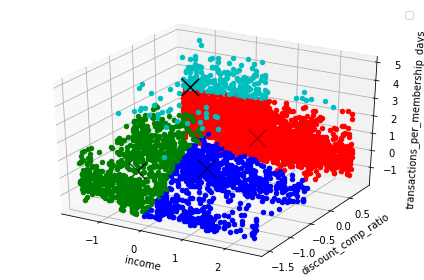

In [ ]:
colors = 10*['r','g','b','c','k','y','m']

#sns.set(style = "darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], marker='o')
ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],
            marker="x",color='k', s=300, linewidths = 30, zorder=20)
ax.legend()

ax.set_xlabel(x4[0])
ax.set_ylabel(x4[1])
ax.set_zlabel(x4[2])

plt.tight_layout()
plt.show()